# Assigment 3 - GraphSage

For this assignment, we'll go through a simple example of how to use GraphSage's algorithm in a similar fashion as [Assignment 1](https://github.com/thmosqueiro/graph-attention-net-genomics-public/blob/main/notebooks/Chapter%201%20-%20Pytorch%20Intro.ipynb). Like before, getting 10 pts in this assignment gives you 100% grade. There are two extra points you can get if you want to go above and beyond (or if you want to catch up from a previous assignment).

For more info:
* https://snap.stanford.edu/graphsage/
* https://arxiv.org/pdf/1706.02216

The original publication uses Tensorflow. PyG (Pytorch Geommetric) implements solutions for Graph NNs, and include GraphSage:
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GraphSAGE.html
Here's their implementation of GraphSage (which is reproduced below):
* https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/basic_gnn.html#GraphSAGE

In case you need to install pyg:

In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [1]:
# imports
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

In [2]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [3]:
# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

* **Question 1 (1 pt):** Visualize the training data using a classical dimensionality reduction technique.

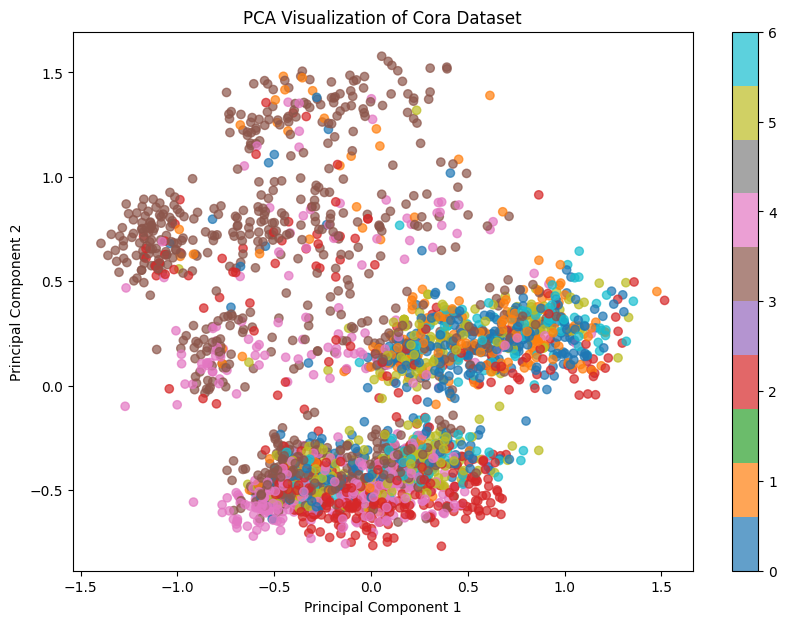

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = dataset[0]

# Perform PCA on the node features
pca = PCA(n_components=2)
node_features = data.x.numpy()
reduced_features = pca.fit_transform(node_features)

# Visualize the 2D projection
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_features[:, 0], 
    reduced_features[:, 1], 
    c=data.y.numpy(), 
    cmap='tab10', 
    alpha=0.7
)

# Add legend and labels
plt.colorbar(scatter, ticks=range(dataset.num_classes))
plt.title('PCA Visualization of Cora Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Use `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` if you'd like to use CUDA.

In [4]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

* **Question 2 (1 pt):** What's "weight decay"?


**Ans:** Weight decay is a regularization technique that that helps prevent overfitting by adding a penalty to the model's weights. The idea is that models with large weights tend to overfit to the training data, so by discouraging this, we can prevent overfitting and help the model generalize better to unseen data. This is equivalent to adding L2 regularization!

In [6]:
# Defining a training step
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [7]:
# Run one iteration
train()
acc = test()
print(f'Accuracy: {acc:.4f}')

/Users/mohit/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy: 0.4640


In [8]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.609
Accuracy on epoch 2: 0.642
Accuracy on epoch 3: 0.666
Accuracy on epoch 4: 0.676
Accuracy on epoch 5: 0.686
Accuracy on epoch 6: 0.691
Accuracy on epoch 7: 0.695
Accuracy on epoch 8: 0.694
Accuracy on epoch 9: 0.693
Accuracy on epoch 10: 0.697
Accuracy on epoch 11: 0.696
Accuracy on epoch 12: 0.697
Accuracy on epoch 13: 0.699
Accuracy on epoch 14: 0.701
Accuracy on epoch 15: 0.699
Accuracy on epoch 16: 0.702
Accuracy on epoch 17: 0.703
Accuracy on epoch 18: 0.703
Accuracy on epoch 19: 0.702
Accuracy on epoch 20: 0.704
Accuracy on epoch 21: 0.706
Accuracy on epoch 22: 0.706
Accuracy on epoch 23: 0.704
Accuracy on epoch 24: 0.701
Accuracy on epoch 25: 0.702
Accuracy on epoch 26: 0.703
Accuracy on epoch 27: 0.704
Accuracy on epoch 28: 0.705
Accuracy on epoch 29: 0.705
Accuracy on epoch 30: 0.707
Accuracy on epoch 31: 0.708
Accuracy on epoch 32: 0.709
Accuracy on epoch 33: 0.709
Accuracy on epoch 34: 0.707
Accuracy on epoch 35: 0.707
Accuracy on epoch 36: 0.706
A

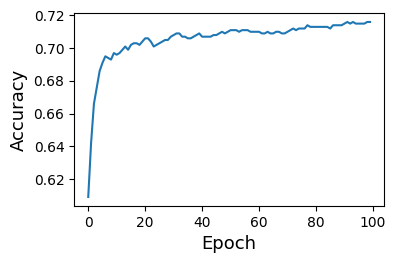

In [9]:
import pylab as pl
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

## Questions

* **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

**Ans:** As seen below, the model predicts classes 2 and 3 the best (about 80%) as opposed to classes 1 and 6 which it predicts the worst (about 50-60%).


* **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

**Ans:** In the Random Walk model, we first use Node2Vec in order to embed the graph's nodes into a vector space. We then trained a classifier on these embeddings to predict the vector of unseen nodes. While this is a valid approach, it takes more computational resources and is less effective compared to GraphSage. Additionally, the GCN model is transductive rather than inductive because it performs agg

* **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

**Ans:** (See code below). The default aggregation function is `mean`. The final test accuracy is slightly better than the default model (72%).

* **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

**Ans:** (See code below). After adding an additional layer, the model had increased performance with an accuracy (80%). Adding another layer contributes to model complexity allowing to learn better and infer new embeddings with better accuracy.

* **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

**Ans:** (See code and graph below). After adding dropout, the performance increased to 81.3%. The ROC curve was slightly different compared to the original model in that there was a clear drop in accuracy but it eventually built up towards the end of training. Dropout regularization helps prevent overfitting by randomly removing neurons so we expect test accuracy to increase.

* **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.

**Ans:** For this question I decided to try out the CiteSeer dataset. This is a similar dataset to Cora in that nodes mean scientific publications and edges mean citation relationships. Each node has a predefined feature with 3703 dimensions. The dataset is designed for the node classification task. The task is to predict the category of certain publication. Unfortunately, the accuracy on this new dataset wasn't as good as Cora (~70%). Hopefully with more testing and tuning the model will be able to perform just as well if not better.


Good luck! :)

#### Question 3 - Performance across classes

In [16]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate(mask):
    model.eval()
    out = model(dataset.data)
    pred = out[mask].argmax(dim=1)  # Get the predicted class labels
    true = data.y[mask]             # True class labels
    
    # Compute overall accuracy
    acc = accuracy_score(true.cpu(), pred.cpu())
    
    # Compute class-wise accuracy and other metrics
    report = classification_report(true.cpu(), pred.cpu(), output_dict=True)
    
    print(f'Overall Accuracy: {acc:.4f}\n')
    print("Class-wise Accuracy:")
    for label, metrics in report.items():
        if label.isdigit():  # Ignore summary keys like 'macro avg' or 'weighted avg'
            print(f"Class {label}: {metrics['precision']:.4f}")
    
    return acc

# Evaluate on the test set
test_acc = evaluate(data.test_mask)

Overall Accuracy: 0.7160

Class-wise Accuracy:
Class 0: 0.6174
Class 1: 0.5878
Class 2: 0.8741
Class 3: 0.8701
Class 4: 0.6821
Class 5: 0.6574
Class 6: 0.5342


/Users/mohit/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


#### Question 5 - Changing the aggregation function

In [9]:
# model definition
class GraphSAGEMax(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)
    
# Setting up the model
model_max = GraphSAGEMax(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model_max.parameters(), lr=0.01, weight_decay=5e-4)

# Defining a training step
def train():
    model_max.train()
    optimizer.zero_grad()
    out = model_max(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model_max.eval()
    with torch.no_grad():
        out = model_max(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [10]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.51
Accuracy on epoch 2: 0.648
Accuracy on epoch 3: 0.697
Accuracy on epoch 4: 0.713
Accuracy on epoch 5: 0.72
Accuracy on epoch 6: 0.725
Accuracy on epoch 7: 0.727
Accuracy on epoch 8: 0.728
Accuracy on epoch 9: 0.722
Accuracy on epoch 10: 0.722
Accuracy on epoch 11: 0.719
Accuracy on epoch 12: 0.715
Accuracy on epoch 13: 0.712
Accuracy on epoch 14: 0.707
Accuracy on epoch 15: 0.707
Accuracy on epoch 16: 0.708
Accuracy on epoch 17: 0.708
Accuracy on epoch 18: 0.708
Accuracy on epoch 19: 0.707
Accuracy on epoch 20: 0.708
Accuracy on epoch 21: 0.71
Accuracy on epoch 22: 0.709
Accuracy on epoch 23: 0.709
Accuracy on epoch 24: 0.709
Accuracy on epoch 25: 0.709
Accuracy on epoch 26: 0.709
Accuracy on epoch 27: 0.709
Accuracy on epoch 28: 0.707
Accuracy on epoch 29: 0.707
Accuracy on epoch 30: 0.707
Accuracy on epoch 31: 0.707
Accuracy on epoch 32: 0.706
Accuracy on epoch 33: 0.706
Accuracy on epoch 34: 0.706
Accuracy on epoch 35: 0.706
Accuracy on epoch 36: 0.706
Accu

#### Question 6 - Adding an additional layer

In [15]:
# model definition
hidden_dim = 400
class GraphSAGE2(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
# Setting up the model
model_2 = GraphSAGE2(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01, weight_decay=5e-4)

# Defining a training step
def train():
    model_2.train()
    optimizer.zero_grad()
    out = model_2(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model_2.eval()
    with torch.no_grad():
        out = model_2(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [17]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.798
Accuracy on epoch 2: 0.798
Accuracy on epoch 3: 0.798
Accuracy on epoch 4: 0.798
Accuracy on epoch 5: 0.799
Accuracy on epoch 6: 0.799
Accuracy on epoch 7: 0.799
Accuracy on epoch 8: 0.799
Accuracy on epoch 9: 0.798
Accuracy on epoch 10: 0.798
Accuracy on epoch 11: 0.798
Accuracy on epoch 12: 0.798
Accuracy on epoch 13: 0.798
Accuracy on epoch 14: 0.799
Accuracy on epoch 15: 0.799
Accuracy on epoch 16: 0.799
Accuracy on epoch 17: 0.799
Accuracy on epoch 18: 0.799
Accuracy on epoch 19: 0.8
Accuracy on epoch 20: 0.8
Accuracy on epoch 21: 0.8
Accuracy on epoch 22: 0.8
Accuracy on epoch 23: 0.8
Accuracy on epoch 24: 0.801
Accuracy on epoch 25: 0.8
Accuracy on epoch 26: 0.8
Accuracy on epoch 27: 0.8
Accuracy on epoch 28: 0.8
Accuracy on epoch 29: 0.8
Accuracy on epoch 30: 0.8
Accuracy on epoch 31: 0.8
Accuracy on epoch 32: 0.8
Accuracy on epoch 33: 0.8
Accuracy on epoch 34: 0.8
Accuracy on epoch 35: 0.8
Accuracy on epoch 36: 0.801
Accuracy on epoch 37: 0.801
Accur

#### Question 7 - Adding dropout regularization

In [28]:
# model definition
hidden_dim = 500
class GraphSAGEDrop(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.25)
        self.conv2 = SAGEConv(hidden_dim, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
# Setting up the model
model_3 = GraphSAGEDrop(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01, weight_decay=5e-4)

# Defining a training step
def train():
    model_3.train()
    optimizer.zero_grad()
    out = model_3(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model_3.eval()
    with torch.no_grad():
        out = model_3(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [29]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.738
Accuracy on epoch 2: 0.784
Accuracy on epoch 3: 0.784
Accuracy on epoch 4: 0.785
Accuracy on epoch 5: 0.783
Accuracy on epoch 6: 0.785
Accuracy on epoch 7: 0.785
Accuracy on epoch 8: 0.785
Accuracy on epoch 9: 0.785
Accuracy on epoch 10: 0.784
Accuracy on epoch 11: 0.783
Accuracy on epoch 12: 0.782
Accuracy on epoch 13: 0.78
Accuracy on epoch 14: 0.781
Accuracy on epoch 15: 0.781
Accuracy on epoch 16: 0.779
Accuracy on epoch 17: 0.776
Accuracy on epoch 18: 0.775
Accuracy on epoch 19: 0.774
Accuracy on epoch 20: 0.77
Accuracy on epoch 21: 0.768
Accuracy on epoch 22: 0.764
Accuracy on epoch 23: 0.761
Accuracy on epoch 24: 0.76
Accuracy on epoch 25: 0.761
Accuracy on epoch 26: 0.763
Accuracy on epoch 27: 0.761
Accuracy on epoch 28: 0.76
Accuracy on epoch 29: 0.76
Accuracy on epoch 30: 0.761
Accuracy on epoch 31: 0.764
Accuracy on epoch 32: 0.767
Accuracy on epoch 33: 0.769
Accuracy on epoch 34: 0.77
Accuracy on epoch 35: 0.773
Accuracy on epoch 36: 0.777
Accurac

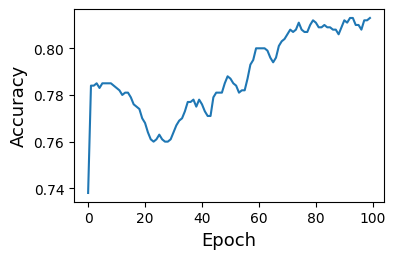

In [31]:
import pylab as pl
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

#### Question 8 - Trying a new Dataset

In [5]:
dataset_2 = Planetoid(root='/tmp/CiteSeer', name='CiteSeer')

Processing...
Done!


In [14]:
# model definition
hidden_dim = 1000
class GraphSAGEDrop(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.conv2 = SAGEConv(hidden_dim, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
# Setting up the model
model_3 = GraphSAGEDrop(dataset_2.num_node_features, dataset_2.num_classes)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01, weight_decay=5e-4)

# Defining a training step
def train():
    model_3.train()
    optimizer.zero_grad()
    out = model_3(dataset_2.data)
    loss = F.nll_loss(out[dataset_2.data.train_mask], dataset_2.data.y[dataset_2.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model_3.eval()
    with torch.no_grad():
        out = model_3(dataset_2.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset_2.data.test_mask] == dataset_2.data.y[dataset_2.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset_2.data.test_mask.sum())
        return acc

In [15]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.659
Accuracy on epoch 2: 0.631
Accuracy on epoch 3: 0.608
Accuracy on epoch 4: 0.576
Accuracy on epoch 5: 0.551
Accuracy on epoch 6: 0.525
Accuracy on epoch 7: 0.514
Accuracy on epoch 8: 0.501
Accuracy on epoch 9: 0.499
Accuracy on epoch 10: 0.499
Accuracy on epoch 11: 0.498
Accuracy on epoch 12: 0.497
Accuracy on epoch 13: 0.497
Accuracy on epoch 14: 0.496
Accuracy on epoch 15: 0.494
Accuracy on epoch 16: 0.496
Accuracy on epoch 17: 0.501
Accuracy on epoch 18: 0.504
Accuracy on epoch 19: 0.512
Accuracy on epoch 20: 0.516
Accuracy on epoch 21: 0.524
Accuracy on epoch 22: 0.525
Accuracy on epoch 23: 0.53
Accuracy on epoch 24: 0.537
Accuracy on epoch 25: 0.543
Accuracy on epoch 26: 0.547
Accuracy on epoch 27: 0.556
Accuracy on epoch 28: 0.563
Accuracy on epoch 29: 0.572
Accuracy on epoch 30: 0.588
Accuracy on epoch 31: 0.595
Accuracy on epoch 32: 0.612
Accuracy on epoch 33: 0.621
Accuracy on epoch 34: 0.633
Accuracy on epoch 35: 0.639
Accuracy on epoch 36: 0.655
Ac